In [135]:
import itertools
import os
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

from efficient_kan.kan import KAN
from kan_convolutional import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TRAININGSET + TESTSET DEFINITION

In [259]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 1), key=lambda idx: train_dataset.targets[idx])
train_subset = torch.utils.data.Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

# MultiTask training sets
train_loader_tasks=[]
for k in range(5):
    sorted_indices =list(filter(lambda idx:train_dataset.targets[idx] in range(k*2,k*2+2), range(len(train_dataset))))
    train_loader_tasks.append(DataLoader(torch.utils.data.Subset(train_dataset, sorted_indices),batch_size=64, shuffle=True))

# Test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(len(test_dataset) // 1))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)


12665 range(0, 2)
12089 range(2, 3)
11263 range(4, 4)
12183 range(6, 5)
11800 range(8, 6)


# ARCHITECTURES DEFINITION

In [3]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# KAN
class KAN_small(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KAN_small, self).__init__()
        self.model = KAN([28 * 28, 128, 10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)


class KAN_big(nn.Module):
    def __init__(self, device=device):
        super(KAN_big, self).__init__()
        self.model = KAN([28 * 28, 28 * 28, 128, 10]).to(device)

    def forward(self, x):
        return self.model(x)

In [5]:
# KAN_Convolutional_Layer + MLP
class CKAN_BN(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn2 = nn.BatchNorm2d(25)

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [6]:
# KAN_Convolutional_Layer + MLP (without Batch Norm)
class KANC_MLP(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [7]:
# Conv2d + KAN
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # KAN layer
        self.kan1 = KANLinear(
            245,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [8]:
# Conv2d + MLP + (Dropout)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        #x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout3(x)
        x = self.fc2(x)

        #x = F.log_softmax(x, dim=1)
        return x

In [9]:
# KAN_Convolutional_Layer + KAN
class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.kan1 = KANLinear(
            625,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)

        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [10]:
# Conv2d + MLP
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x


class SimpleCNN_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(5, 25, kernel_size=3, padding=0)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(625, 245)
        self.fc2 = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

# TRAIN() AND TEST() FUNCTIONS

In [88]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0):
    criterion = nn.CrossEntropyLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        losses = []
        accuracies = []
        epoch_start = time.time_ns()
        with tqdm(train_loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                    images = images.view(-1, 28 * 28)
                optimizer.zero_grad()
                output = model(images.to(device))
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                losses.append(loss.item())
                accuracies.append(accuracy.item())
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, losses, accuracies, epoch_duration, lr)
        torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

In [16]:
def test(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                images = images.view(-1, 28 * 28)
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

# BATCH TESTS

In [90]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, subdir='') -> list['EpochStat']:
        return [pickle.load(open(f'checkpoint/stats/{subdir}{file}', 'rb')) for file in
                filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'checkpoint/stats/{subdir}'))]

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies

    def save(self):
        pickle.dump(self, open(f'checkpoint/stats/{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_losses, train_accuracies, epoch_duration, lr):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_losses[-1], test_loss, labels, predictions, epoch_duration,
                     lr, train_losses, train_accuracies)
    stat.save()

In [35]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]

In [ ]:
for model in [x.to(device) for x in models[:2]]:
    print(f'Training model={model.__class__.__name__}')
    lr = 1e-5 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-4
    train(model, f'checkpoint/{model.__class__.__name__}', epochs=1, start_epoch=0,
          optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)

# RESULTS PLOTTING

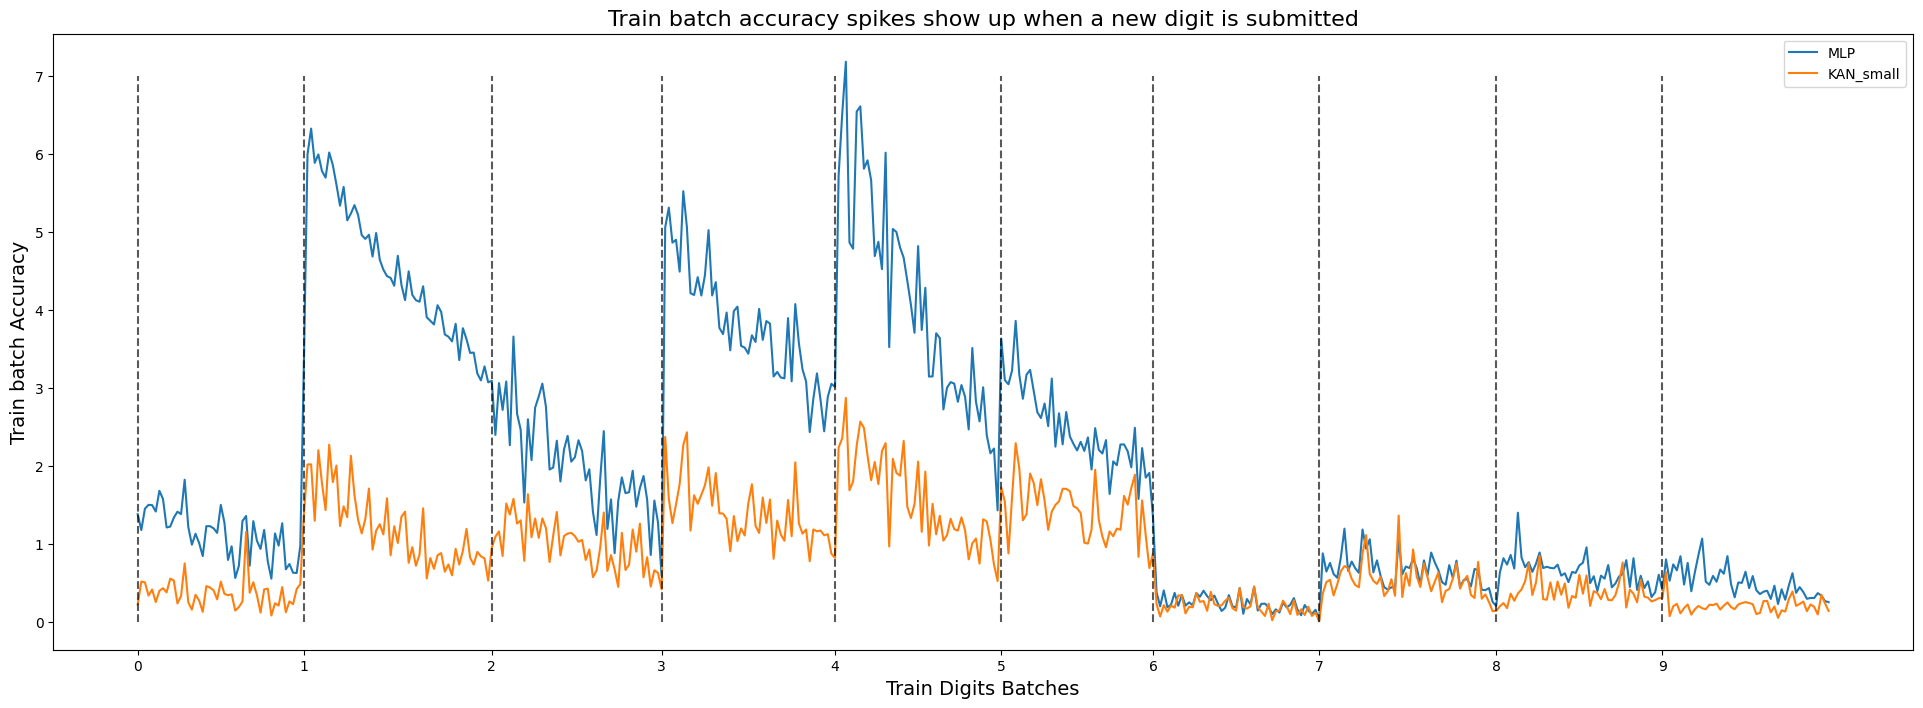

In [252]:
fig, ax = plt.subplots()
batches = [
    0,
    5923,
    6742,
    5958,
    6131,
    5842,
    5421,
    5918,
    6265,
    5851,
    # 5949,
]
granularity = 2
for name in list(map(lambda e: e.__class__.__name__, models[:2])):
    stats = EpochStat.loadModelStats(name, subdir='')
    ax.plot(list(map(lambda e: e.train_losses, stats))[0][::granularity], label=name)
plt.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks([x//64//granularity for x in itertools.accumulate(batches)])
ax.set_xticklabels(range(10))
plt.vlines(x=[x//64//granularity for x in itertools.accumulate(batches)], ymin=0, ymax=7, colors='black',alpha=0.65, linestyles='dashed')
plt.xlabel('Train Digits Batches', fontdict={'fontsize':14})
plt.ylabel('Train batch Accuracy', fontdict={'fontsize':14})
plt.title('Train batch accuracy spikes show up when a new digit is submitted', fontdict={'fontsize':16})
fig.set_size_inches(24, 8)
plt.show()